# Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import ExcelWriter, ExcelFile, read_excel, DataFrame
from openpyxl import load_workbook
import cv2
import sys
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import time
import seaborn as sns
import joblib
from joblib import dump, load
sys.modules['sklearn.externals.joblib'] = joblib

# Reading data function

In [2]:
def readExcelSheet1(excelfile):
    return (read_excel(excelfile)).values

def readExcelRange(excelfile,sheetname="Sheet1",startrow=1,endrow=1,startcol=1,endcol=1):
    values=(read_excel(excelfile, sheetname,header=None)).values;
    return values[startrow-1:endrow,startcol-1:endcol]

def readExcel(excelfile,**args):
    if args:
        data=readExcelRange(excelfile,**args)
    else:
        data=readExcelSheet1(excelfile)
    [nr,nc]=data.shape
    if [nr,nc]==[1,1]:
        return data[0,0]
    elif min([nr,nc])==1:
        return np.squeeze(data)
    else:
        return data

## Reading data function call

In [3]:
excelfile=r"64x64.xlsx"
X = readExcel(excelfile)

In [4]:
df = pd.DataFrame(X)
df.iloc[: , -1].value_counts() / df.shape[0]

2    0.40458
0    0.29771
1    0.29771
Name: 4096, dtype: float64

Text(0, 0.5, 'Count')

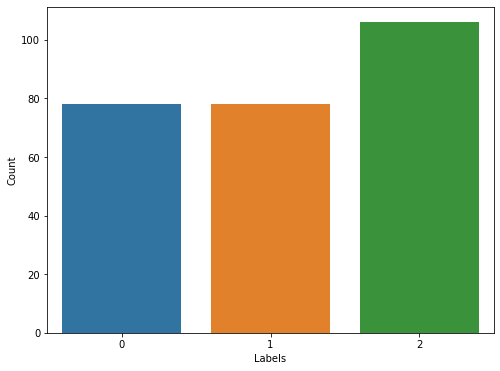

In [5]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x=4096,data=df)
plt.title('')
plt.xlabel('Labels')
plt.ylabel('Count')


In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,234,135,64,71,64,44,24,48,65,71,...,201,253,218,196,171,176,182,189,193,0
1,38,39,39,36,37,37,33,30,42,54,...,106,110,110,107,110,112,118,131,137,0
2,102,101,102,99,100,91,221,255,255,255,...,106,110,120,82,93,100,99,100,99,0
3,169,186,175,183,200,182,118,106,98,166,...,37,32,29,29,30,32,30,32,63,0
4,87,86,87,89,72,30,12,4,1,28,...,129,140,149,118,40,53,71,71,72,0


## Data Splitting

In [7]:
target = df.iloc[:,-1]
df.drop(columns=df.columns[-1], axis=1, inplace=True)
data = df

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,234,135,64,71,64,44,24,48,65,71,...,186,201,253,218,196,171,176,182,189,193
1,38,39,39,36,37,37,33,30,42,54,...,100,106,110,110,107,110,112,118,131,137
2,102,101,102,99,100,91,221,255,255,255,...,103,106,110,120,82,93,100,99,100,99
3,169,186,175,183,200,182,118,106,98,166,...,32,37,32,29,29,30,32,30,32,63
4,87,86,87,89,72,30,12,4,1,28,...,124,129,140,149,118,40,53,71,71,72


In [9]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: 4096, dtype: int64

In [10]:
print('Size')
print("Dataset(row,column) :" ,data.shape )
print("Dataset(row,column) :" ,target.shape )

Size
Dataset(row,column) : (262, 4096)
Dataset(row,column) : (262,)


In [11]:
data_train, data_test, label_train, label_test = train_test_split( data, target, test_size=0.1, random_state=0)
K=data_test

In [12]:
print('Size after test-train split')
print("Dataset(row,column) :" ,data_train.shape )
print("Dataset(row,column) :" ,data_test.shape )

Size after test-train split
Dataset(row,column) : (235, 4096)
Dataset(row,column) : (27, 4096)


## Dimentional Reduction - PCA

In [13]:
pca = PCA(n_components = 0.99)
pca.fit(data_train)
joblib.dump(pca, 'pca.joblib')
pca = joblib.load('pca.joblib')
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [14]:
print('Size after PCA')
print("Dataset(row,column) :" ,data_train.shape )
print("Dataset(row,column) :" ,data_test.shape )

Size after PCA
Dataset(row,column) : (235, 174)
Dataset(row,column) : (27, 174)


## Machine Learning Model - Support Vector Machines

In [15]:
svm = SVC(C=0.01,kernel='linear',tol=0.01,verbose=False,gamma = 1e-8)

In [16]:
svm.fit(data_train, label_train) 

SVC(C=0.01, gamma=1e-08, kernel='linear', tol=0.01)

In [19]:
svm.score(data_test,label_test)

0.9629629629629629

In [18]:
predicted = svm.predict(data_test)

In [21]:
print(classification_report(label_test, predicted, target_names= ['neutral', 'sad', 'happy']))

              precision    recall  f1-score   support

     neutral       0.86      1.00      0.92         6
         sad       1.00      0.89      0.94         9
       happy       1.00      1.00      1.00        12

    accuracy                           0.96        27
   macro avg       0.95      0.96      0.95        27
weighted avg       0.97      0.96      0.96        27



<AxesSubplot:>

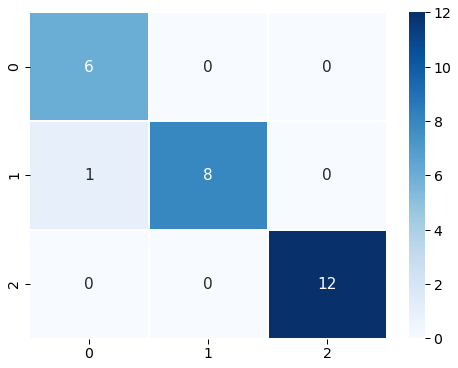

In [22]:
cm = confusion_matrix(label_test, predicted)
plt.figure(figsize=(8,6))
sns.set_context('paper', font_scale = 1.6)
sns.heatmap(cm, annot = True, linecolor='white',linewidth=1,cmap="Blues")  

#### Model Saving

In [23]:
joblib.dump(svm, "svm.joblib") 

['svm.joblib']

# Face Detection & Real-Time Classification 

In [24]:
def classify_img(face_img):
    pca = joblib.load('pca.joblib') 
    svm = joblib.load('svm.joblib') 
    face_img = cv2.resize(face_img,(64,64))
    face_img = face_img.reshape(1,4096)
    face_img = pca.transform(face_img)
    return svm.predict(face_img)
    

In [25]:
def Get_face(img):
    face_cascade = cv2.CascadeClassifier( "haarcascade_frontalface_alt.xml")
    return face_cascade.detectMultiScale(img)

In [25]:
cam = cv2.VideoCapture(0)
cv2.namedWindow("Facial_Emotion")
res = None

while cv2.getWindowProperty('Facial_Emotion', 0) >= 0:
    ret, frame = cam.read()
    gray = frame 
    faces = Get_face(gray)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        face_img = cv2.cvtColor(gray[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)
        time.sleep(0.1)
        res = classify_img(face_img)


        if res == 0:
            cv2.putText(frame, "Neutral", (x-50,h-20), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(0, 0, 255),2)
        elif res ==1:
            cv2.putText(frame, "Sad", (x-50,h-20), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(0, 0, 255),2)
        else:
            cv2.putText(frame, "Happy", (x-50,h-20), cv2.FONT_HERSHEY_SIMPLEX, 1.3,(0, 0, 255),2)

        cv2.imshow("Facial_Emotion", frame)

        if not ret:
            break
   
    key = cv2.waitKey(50)
    if key%256 == 27:
        cam.release()
        cv2.destroyAllWindows()
        break
    
cam.release()
cv2.destroyAllWindows()